# Estimation of signal and background yields

In [2]:
import numpy as np
import numpy.random as rm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize
from scipy.sparse import identity
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import poisson
from scipy.stats import expon
from scipy.stats import cauchy
from scipy.special import erf
from scipy.stats import gaussian_kde

plt.rc('font', family='serif', size = 16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams["figure.figsize"] = (10,8)

In [3]:
## code used to generate the data (not needed for the exercise)
expected = poisson.rvs((182.3,420.7))
sig_data = np.array([])
while len(sig_data) < expected[0]:
    val = norm.rvs(loc=1,scale=0.25)
    if val >=0 and val <=2:
        sig_data = np.append(sig_data,[val])
bkg_data = uniform.rvs(loc=0,scale=2,size=expected[1])
data = np.concatenate((bkg_data,sig_data))
rm.shuffle(data)
pd.DataFrame(data=data,columns=["x"]).to_csv("data/ex9_data.csv.gz", index_label=False, compression="gzip")

In [4]:
## reading the data from .csv file
data = pd.read_csv("/Users/alicetownsend/StatisticalMethods/StatMethods2022/notebooks/data/ex9_data.csv.gz").x # column 'x' of the DataFrame

## 1. Make a graphical representation of the data using a histogram

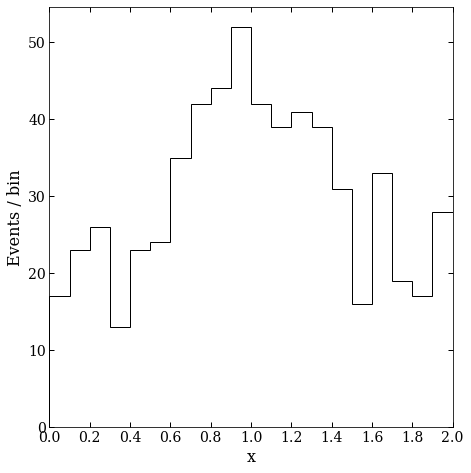

In [5]:
## plotting the data
figure_data_hist = plt.figure(figsize=(8,8))

# histogram of observed data
Nbins=20
bin_size=2/Nbins
data_hist = plt.hist(data,
                     Nbins,
                     edgecolor='black',
                     histtype='step',
                     range=(0.,2.),
                     density=False,
                     figure=figure_data_hist,
                     label=r'data')[0]
plt.xlabel(r'x')
plt.ylabel(r'Events / bin')
plt.xlim(0.,2.)
plt.xticks(np.arange(0.,2.2,0.2))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.20)

## 2. Write the extended log-likelihood function

In [6]:
# pdf for signal and background
def f_sig(x):
    return 2*np.sqrt(2/np.pi)/erf(2*np.sqrt(2))*np.exp(-8*(x-1)**2)
def f_bkg(x):
    return 1/2

# extended likelihood function
def nll_extended(nu_s, nu_b):
    return +nu_s+nu_b-np.sum([np.log(nu_s*f_sig(x)+nu_b*f_bkg(x)) for x in data])

## 3. Find the MLE estimate for $\nu_S$ in the 1D case

In [7]:
# find the MLE estimate in the 1D case
nu_b_1D=420.7
result_1D = minimize(lambda x:nll_extended(nu_s=x[0],nu_b=nu_b_1D),
                    [0.], # list of starting values for the parameters
                    #bounds=[ (-1000., 1000.), (-1000., 1000.), ], # list of (lower, upper) bounds for the parameters
                    options={'disp': True} ) # returns result of the fit
nu_s_1D = result_1D.x[0]
nu_s_stddev_1D = np.sqrt(result_1D.hess_inv.dot(identity(1).toarray())[0][0])
nll_min_1D = result_1D.fun
print("Result (with background yield nu_b={}):".format(nu_b_1D))
print("nu_s = {}+/-{}".format(nu_s_1D,nu_s_stddev_1D))
print("nll_min = {}".format(nll_min_1D))

Optimization terminated successfully.
         Current function value: -2874.713706
         Iterations: 7
         Function evaluations: 20
         Gradient evaluations: 10
Result (with background yield nu_b=420.7):
nu_s = 179.3132080836839+/-19.62747120326197
nll_min = -2874.7137056721367


## 4. Plot the likelihood distribution as a function of $\nu_S$

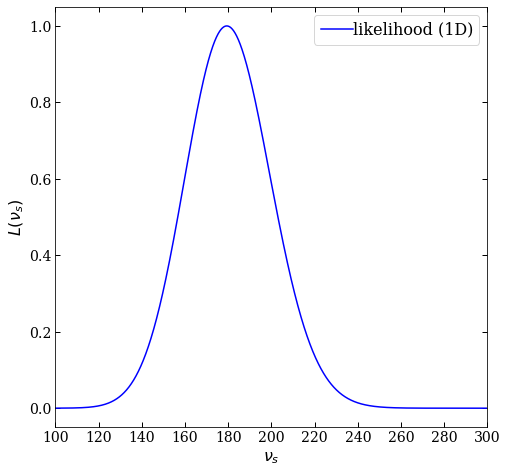

In [8]:
# plot the likelihood distribution
figure_likelihood_1D = plt.figure(figsize=(8,8))

points = np.arange(100,300,0.1)
ll_values = np.array([-nll_extended(point,nu_b_1D) for point in points])
L_values = [np.exp(x+nll_min_1D) for x in ll_values]
plt.plot(points,
         L_values,
         figure=figure_likelihood_1D,
         color='blue',
         label='likelihood (1D)')
plt.xlabel(r'$\nu_s$')
plt.ylabel(r'$L(\nu_s)$')
plt.xlim(100.,300.)
plt.xticks(np.arange(100.,301,20))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.15)
plt.legend(handletextpad=0, loc="best")

## 5, 6, 7. Posteriors in 1D

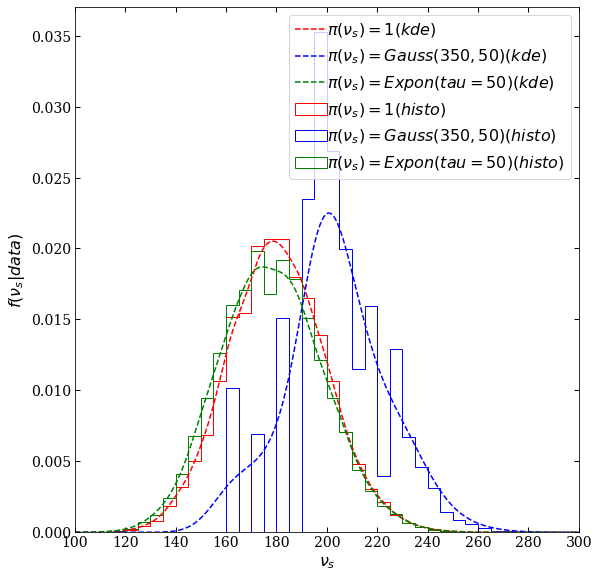

In [9]:
# 5.
# histogram of the posterior, for a uniform prior
figure_posteriors_1D = plt.figure(figsize=(10,10))
Nbins=40
nu_s_values = uniform.rvs(loc=100,scale=200,size=10000)
L_nu_s_values = np.array([np.exp(-nll_extended(x,nu_b_1D)+nll_min_1D) for x in nu_s_values])
posterior_hist = plt.hist(nu_s_values,
                     Nbins,
                     edgecolor='red',
                     histtype='step',
                     range=(100.,300.),
                     density=True,
                     weights=L_nu_s_values,
                     figure=figure_posteriors_1D,
                     label=r'$\pi(\nu_s)=1 (histo)$')[0]
plt.xlabel(r'$\nu_s$')
plt.ylabel(r'$f(\nu_s|data)$')
plt.xlim(100.,300.)
plt.xticks(np.arange(100.,301,20))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.20)


# 6.
# do the same with a Gaussian kernel estimator
kde = gaussian_kde(dataset=nu_s_values,
                   weights=L_nu_s_values)
points = np.arange(100,300,0.1)
plt.plot(points,
         kde.pdf(points),
         color='red',
         linestyle='dashed',
         figure=figure_posteriors_1D,
         label=r'$\pi(\nu_s)=1 (kde)$')

# do the same with a Gaussian prior
Nbins=40
nu_s_values = norm.rvs(loc=350,scale=50,size=10000)
L_nu_s_values = np.array([np.exp(-nll_extended(x,nu_b_1D)+nll_min_1D) for x in nu_s_values])
posterior_hist_2 = plt.hist(nu_s_values,
                     Nbins,
                     edgecolor='blue',
                     histtype='step',
                     range=(100.,300.),
                     density=True,
                     weights=L_nu_s_values,
                     figure=figure_posteriors_1D,
                     label=r'$\pi(\nu_s)=Gauss(350,50) (histo)$')[0]

# do the same with a Gaussian kernel estimator
kde2 = gaussian_kde(dataset=nu_s_values,
                   weights=L_nu_s_values)
points = np.arange(100,300,0.1)
plt.plot(points,
         kde2.pdf(points),
         color='blue',
         linestyle='dashed',
         figure=figure_posteriors_1D,
         label=r'$\pi(\nu_s)=Gauss(350,50) (kde)$')

# Alternative priorr
# do the same with an exponential prior
Nbins=40
nu_s_values = expon.rvs(scale=200,size=10000)
L_nu_s_values = np.array([np.exp(-nll_extended(x,nu_b_1D)+nll_min_1D) for x in nu_s_values])
posterior_hist_3 = plt.hist(nu_s_values,
                     Nbins,
                     edgecolor='green',
                     histtype='step',
                     range=(100.,300.),
                     density=True,
                     weights=L_nu_s_values,
                     figure=figure_posteriors_1D,
                     label=r'$\pi(\nu_s)=Expon(tau=50) (histo)$')[0]

# do the same with a Gaussian kernel estimator
kde3 = gaussian_kde(dataset=nu_s_values,
                   weights=L_nu_s_values)
points = np.arange(100,300,0.1)
plt.plot(points,
         kde3.pdf(points),
         color='green',
         linestyle='dashed',
         figure=figure_posteriors_1D,
         label=r'$\pi(\nu_s)=Expon(tau=50) (kde)$')
plt.legend(handletextpad=0, loc="best")

## 8. Find the MLE estimate for $\nu_S$ and $\nu_B$ in the 1D case

In [10]:
# find the MLE estimate in the 2D case
result_2D = minimize(lambda x:nll_extended(nu_s=x[0],nu_b=x[1]),
                    [100.,100.], # list of starting values for the parameters
                    #bounds=[ (-1000., 1000.), (-1000., 1000.), ], # list of (lower, upper) bounds for the parameters
                    options={'disp': True} ) # returns result of the fit
nu_s_2D = result_2D.x[0]
nu_b_2D = result_2D.x[1]
nu_s_stddev_2D = np.sqrt(result_2D.hess_inv.dot(identity(2).toarray())[0][0])
nu_b_stddev_2D = np.sqrt(result_2D.hess_inv.dot(identity(2).toarray())[1][1])
nll_min_2D = result_2D.fun
print("Result:")
print("nu_s = {}+/-{}".format(nu_s_2D,nu_s_stddev_2D))
print("nu_b = {}+/-{}".format(nu_b_2D,nu_b_stddev_2D))
print("nll_min = {}".format(nll_min_2D))

Optimization terminated successfully.
         Current function value: -2874.751023
         Iterations: 23
         Function evaluations: 81
         Gradient evaluations: 27
Result:
nu_s = 175.40059146554736+/-36.37092597234465
nu_b = 428.6106870564549+/-28.868633449537594
nll_min = -2874.75102341935


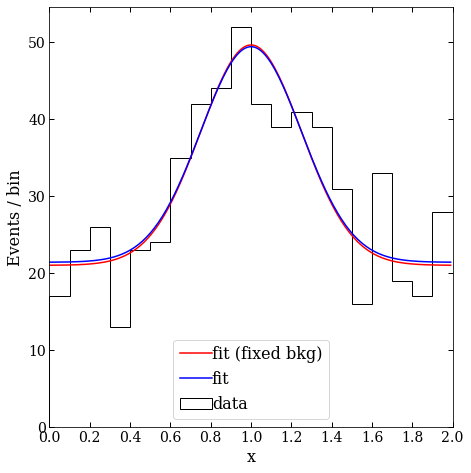

In [11]:
## plotting the data and the fit results
figure_fits = plt.figure(figsize=(8,8))

# histogram of observed data
Nbins=20
bin_size=2/Nbins
data_hist = plt.hist(data,
                     Nbins,
                     edgecolor='black',
                     histtype='step',
                     range=(0.,2.),
                     density=False,
                     figure=figure_fits,
                     label=r'data')[0]
plt.xlabel(r'x')
plt.ylabel(r'Events / bin')
plt.xlim(0.,2.)
plt.xticks(np.arange(0.,2.2,0.2))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.20)

# plot the fit result (1D)
points = np.arange(0,2,0.01)
plt.plot(points,
         (nu_s_1D*f_sig(points)+nu_b_1D*f_bkg(points))*bin_size,
         figure=figure_fits,
         color='red',
         label='fit (fixed bkg)')

# plot the fit result (2D)
newpoints = np.arange(0,2,0.01)
newpoints_values = np.array([(nu_s_2D*f_sig(x)+nu_b_2D*f_bkg(x))*bin_size for x in newpoints])
plt.plot(newpoints,
         newpoints_values,
         figure=figure_fits,
         color='blue',
         label='fit')

plt.legend(handletextpad=0, loc="lower center")

## 9. Plotting the 2D posterior, first with uniform prior

Text(0.5, 1.0, '$f(\\nu_s,\\nu_b|data)$ (uniform prior)')

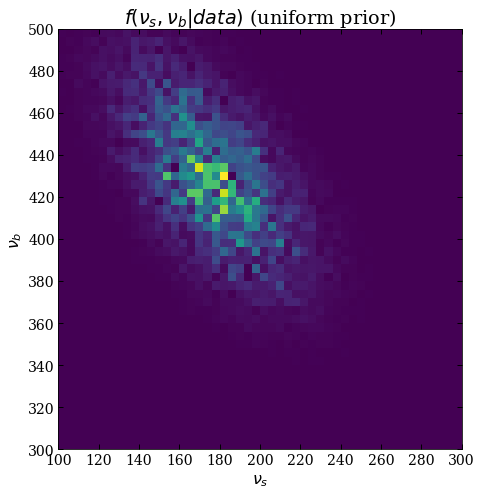

In [12]:
# plotting the 2D posterior, first with uniform prior
figure_posteriors_2D_uniformPrior = plt.figure(figsize=(8,8))
Nbins=50
nu_s_values_2D = uniform.rvs(loc=100,scale=200,size=10000)
nu_b_values_unif = uniform.rvs(loc=300,scale=200,size=10000)
#nu_b_values = norm.rvs(loc=420.7,scale=10,size=10000)
L_nu_s_values_2D = np.array([np.exp(-nll_extended(nu_s_values_2D[i],nu_b_values_unif[i])+nll_min_2D) for i in range(0,nu_s_values_2D.size)])
posterior_hist = plt.hist2d(nu_s_values_2D,nu_b_values_unif,
                     Nbins,
                     range=[[100,300],[300,500]],
                     #density=True, # doesn't work in the version I'm using
                     weights=L_nu_s_values_2D,
                     figure=figure_posteriors_2D_uniformPrior)

plt.xlabel(r'$\nu_s$')
plt.ylabel(r'$\nu_b$')
plt.xlim(100.,300.)
plt.ylim(300.,500.)
plt.xticks(np.arange(100.,301,20))
plt.yticks(np.arange(300.,501,20))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.20)
plt.title(r'$f(\nu_s,\nu_b|data)$ (uniform prior)')

## 10. Plotting the 2D posterior, with Gaussian prior

Text(0.5, 1.0, '$f(\\nu_s,\\nu_b|data)$ (Gauss prior for bkg.)')

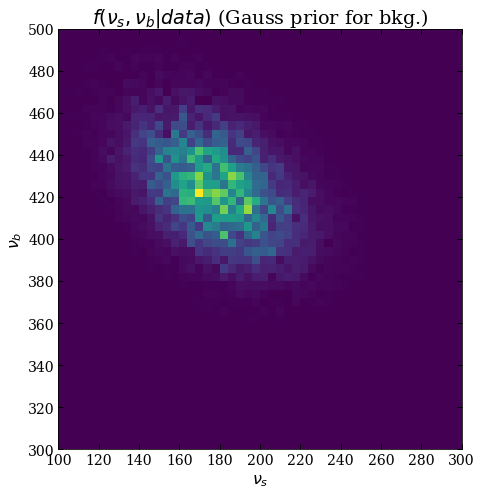

In [13]:
# plotting the 2D posterior, with Gaussian prior
figure_posteriors_2D_GaussPriorBkg = plt.figure(figsize=(8,8))
Nbins=50
nu_b_values_gauss = norm.rvs(loc=420.7,scale=25,size=10000)
L_nu_s_values_gaussbkg = np.array([np.exp(-nll_extended(nu_s_values_2D[i],nu_b_values_gauss[i])+nll_min_2D) for i in range(0,nu_s_values_2D.size)])
posterior_hist = plt.hist2d(nu_s_values_2D,nu_b_values_gauss,
                     Nbins,
                     range=[[100,300],[300,500]],
                     #density=True, # doesn't work in the version I'm using
                     weights=L_nu_s_values_gaussbkg,
                     figure=figure_posteriors_2D_GaussPriorBkg)

plt.xlabel(r'$\nu_s$')
plt.ylabel(r'$\nu_b$')
plt.xlim(100.,300.)
plt.ylim(300.,500.)
plt.xticks(np.arange(100.,301,20))
plt.yticks(np.arange(300.,501,20))
plt.tick_params(direction='in', top=True, right=True)
plt.subplots_adjust(bottom=0.15,left=0.20)
plt.title(r'$f(\nu_s,\nu_b|data)$ (Gauss prior for bkg.)')